Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Juan Gómez y Nicolás Guarín-Zapata 2019. Este material es parte del curso Modelación Computacional en el programa de Ingeniería Civil de la Universidad EAFIT.

# Interpolación por tramos

## Introducción

En el Notebook anterior discutimos el problema de interpolación de Lagrange como un método para aproximar funciones en términos de valores discretos de la función. De acuerdo con esto, si se tenían $N$ valores conocidos de la función era posible proponer una aproximación polinomial de orden $N-1$. Aunque, en principio, esta estrategia parece ser correcta, tiene la desventaja de que el polinomio de interpolación resultante será valido solo para ese problema en particular imposibilitando automatizar el método a un algoritmo general que resuelva cualquier problema. Una solución posible a esta falta de generalidad es adoptar un esquema de interpolación basado en la división del dominio original en sub-dominios en el done el esquema de interpolación es implementado para un sub-dominio general con un numero fijo de puntos discretos o nodos. En esta estrategia la muestra de $N$ valores de la función es dividida en sub-dominios, por ejemplo en pares de puntos, dando como resultado una función de interpolación que es continua por tramos. En este Notebook cubrimos los aspectos básicos de este esquema de interpolación basado en sub-dominios.

**Al completar este notebook usted debería estar en la capacidad de:**

* Reconocer las diferencias entre un esquema de interpolación global y uno local.

* Reconocer las ventajas y desventajas de los esquemas de interpolación local y global.

* Formular e implementar esquemas de interpolación local en Python.

* Reconocer un elemento finito como un esquema de interpolación local.

## Esquema global

En la siguiente celda, pruebe a cambiar la línea `%matplotlib notebook` por
`%matplotlib inline`y ejecute el código de todas las celdas para ver la diferencia.


In [1]:
%matplotlib notebook        
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import sympy as sym

Conisderemos la misma función usada en el problema de interpolación del Notebook anterior y definida como:

 $$ f(x)=x^3+4x^2-10 $$
 
con $x$ en el intervalo $\left[ {{-1},{1}} \right]$. Asumamos también que conocemos el valor exacto de la función en los puntos $[-1, -0.5, 0, 0.5, 1]$. Nos referiremos a estos puntos como los **nodos**. Determinaremos un único polinomio de interpolación de Lagrange usando los 5 valores conocidos de la función en los nudos dados. El siguiente bloque de código muestra los pasos requeridos en este esquema global.


In [2]:
def lagrange_poly(x, order, i, xi=None): 
    if xi == None:
        xi = sym.symbols('x:%d'%(order+1))
    index = list(range(order+1))
    index.pop(i)
    return sym.prod([(x-xi[j])/(xi[i]-xi[j]) for j in index])

<IPython.core.display.Javascript object>


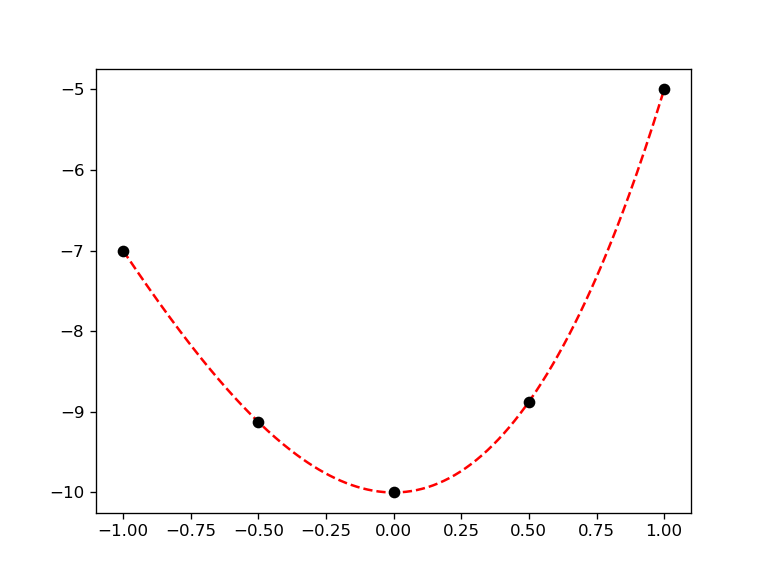

In [3]:
fx = lambda x: x**3+4.0*x**2-10.0
fdx = lambda x: 3*x**2+8.0*x 

npts = 200
xx = np.linspace(-1, 1, npts)  
x_data = np.array([-1, -0.5 , 0.0 , 0.5, 1])
fd = fx(x_data)

plt.figure(0)
yy = fx(xx) 
plt.plot(xx, yy ,'r--')
plt.plot([-1, -0.5 , 0.0 , 0.5, 1], fd, 'ko')

### Polinomios de Lagrange locales

Ahora dividimos el dominio del problema correspondiente a $x \in \left[ {{-1},{1}} \right]$ en  sub-dominios de tamaño constante. Cada sub-dominio estará conformado por 2 **nodos** que serán usados para definir polinomios de interpolación de orden 1.

En el siguiente bloque de código calculamos polinomios para cada nudo de estos sub-dominios de tamaño $\Delta x=0.5$. En este esquema, cada polinomio solo existirá en el sub-dominio dado y además los polinomios de cada sub-dominio son exactamente los mismos. Esto indica que una implementación más general y potente debería calcular los polinomios lineales una sola vez y usarlos recursivamente en la construcción de la función de aproximación.


In [4]:
# Adicione comentarios para aclarar los pasos mas relevantes del siguiente
# bloque de código
x = sym.symbols('x')
pol = []
pol.append(sym.simplify(lagrange_poly(x, 1, 0, [-1.0, -0.5])))
pol.append(sym.simplify(lagrange_poly(x, 1, 1, [-1.0, -0.5])))
pol.append(sym.simplify(lagrange_poly(x, 1, 0, [-0.5,  0.0])))
pol.append(sym.simplify(lagrange_poly(x, 1, 1, [-0.5,  0.0])))
pol.append(sym.simplify(lagrange_poly(x, 1, 0, [ 0.0,  0.5])))
pol.append(sym.simplify(lagrange_poly(x, 1, 1, [ 0.0,  0.5])))
pol.append(sym.simplify(lagrange_poly(x, 1, 0, [ 0.5,  1.0])))
pol.append(sym.simplify(lagrange_poly(x, 1, 1, [ 0.5,  1.0])))

<IPython.core.display.Javascript object>


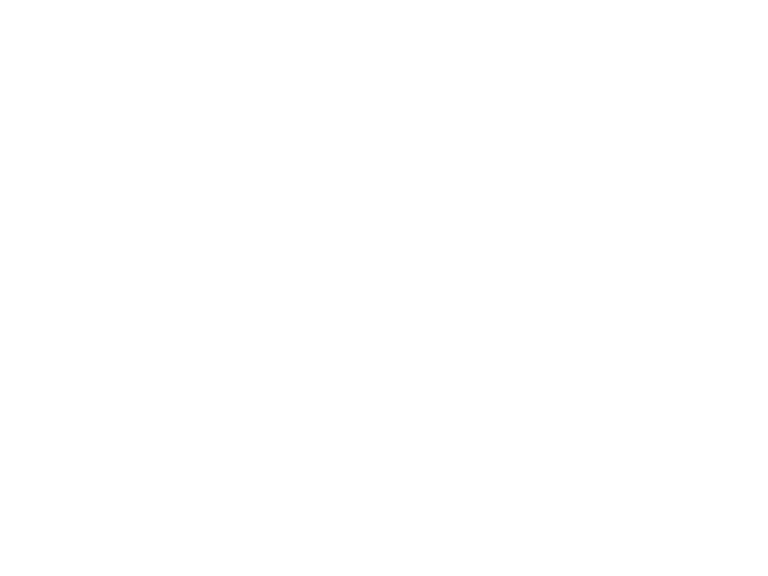

In [5]:
plt.figure()
xx = np.linspace(-1, -0.5, npts)
for k in range(2):
    for i in range(npts):
        yy[i] =  pol[k].subs([(x, xx[i])])
    plt.plot(xx, yy)

xx = np.linspace(-0.5, 0.0, npts)
for k in range(2):
    for i in range(npts):
        yy[i] =  pol[k + 2].subs([(x, xx[i])])
    plt.plot(xx, yy)

xx = np.linspace(0.0, 0.5, npts)
for k in range(2):
    for i in range(npts):
        yy[i] =  pol[k + 4].subs([(x, xx[i])])
    plt.plot(xx, yy)

xx = np.linspace(0.5, 1.0, npts)
for k in range(2):
    for i in range(npts):
        yy[i] =  pol[k + 6].subs([(x, xx[i])])
    plt.plot(xx, yy)

### Polinomio de interpolación $p(x)$ para aproximar la  función $f(x)$


Construyamos ahora el polinomio de aproximación completo $p(x)$. Ya que cada polinomio existe localmente sobre cada sub-dominio podemos usar:

$$p(x) = L_L(x)f(x_L) + L_R(x)f(x_R)$$

donde $f(x_L)$ y $f(x_R)$ son los valores de la función en los extremos izquierdo y derecho del sub-dominio, mientras que $L_L(x)$ y $L_R(x)$ son los respectivos polinomios de primer orden asociados a estos puntos.

En el próximo bloque de código aproximamos la función desconocida $f(x)$ en cada sub-dominio usando los 2 polinomios de Lagrange locales. En la gráfica los puntos negros representan los valores nodales o exactos de la función, mientras que la línea continua representa la función exacta.


<div class="alert alert-warning">

**Pregunta**

Sugiera una estrategia para mejorar la aproximación a la función $f(x)$ pero usando la idea de polinomios de interpolación locales.

</div>



<IPython.core.display.Javascript object>


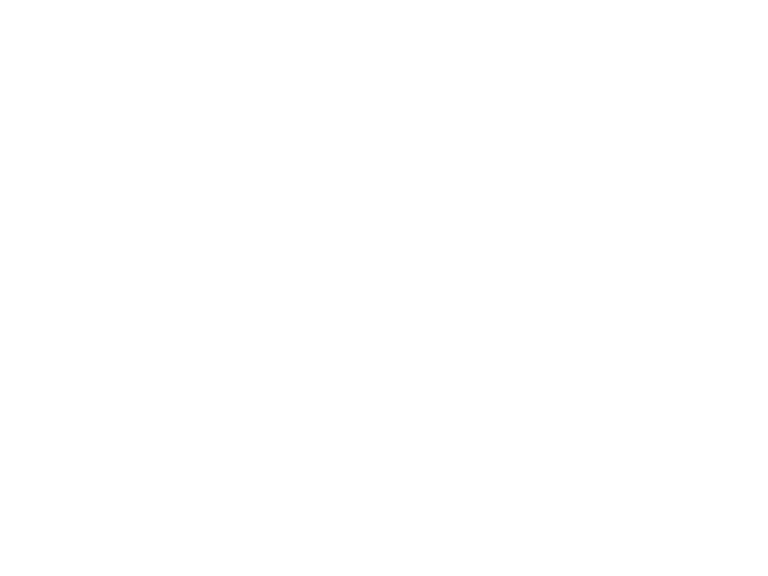

In [6]:
# Adicione comentarios para aclarar los pasos mas relevantes del siguiente bloque
# de código
plt.figure()
plt.grid()

xx = np.linspace(-1.0, -0.5, npts)
for i in range(npts):
    yy[i] = fd[0]*pol[0].subs([(x, xx[i])]) + fd[1]*pol[1].subs([(x, xx[i])])
plt.plot(xx, yy)

xx = np.linspace(-0.5, 0.0, npts)
for i in range(npts):
    yy[i] = fd[1]*pol[2].subs([(x, xx[i])]) + fd[2]*pol[3].subs([(x, xx[i])])
plt.plot(xx, yy)

xx = np.linspace( 0.0, 0.5, npts)
for i in range(npts):
    yy[i] = fd[2]*pol[4].subs([(x, xx[i])]) + fd[3]*pol[5].subs([(x, xx[i])])
plt.plot(xx, yy)

xx = np.linspace( 0.5, 1.0, npts)
for i in range(npts):
    yy[i] = fd[3]*pol[6].subs([(x, xx[i])]) + fd[4]*pol[7].subs([(x, xx[i])])
plt.plot(xx, yy)

xx = np.linspace(-1.0, 1.0, npts)
zz = fx(xx)
plt.plot(xx, zz)
plt.plot([-1, -0.5, 0, 0.5, 1], fd, 'ko')

### Variables secundarias



El término variable secundaria corresponde a aquellas funciones que son obtenidas usando la función aproximada $p(x)$. Por ejemplo, asumamos que en el problema actual también estamos interesados en las derivadas de primer orden de la función $f(x)$ pero no tenemos valores nodales para realizar la interpolación. Sin embargo podemos usar la aproximación $p(x)$ de $f(x)$ como:


$$p'(x) = \frac{\mathrm{d}L_L(x)}{\mathrm{d}x} f(x_L) + \frac{\mathrm{d}L_R(x)}{\mathrm{d}x}f(x_R)\, .$$

El siguiente bloque de código grafica los valores conocidos de las primeras derivadas (puntos negros), las derivada exacta $f'(x)$ (línea azul) y las derivadas calculadas con el esquema local. Nótese que debido a que en cada intervalo la función es aproximada por una función lineal la derivada resultante es una función constante a tramos y, por tanto,  discontinua entre los sub-intervalos.


<div class="alert alert-warning">

**Preguntas**

- Proponga una alternativa para mejorar la aproximación a la derivada de primer orden de la función mostrada.

- ¿Cómo están relacionadas las discontinuidades en la primera derivada con la función local?
</div>

In [7]:
dpol = []
for j in range(8):
    dpol.append(sym.diff(pol[j],x))

<IPython.core.display.Javascript object>


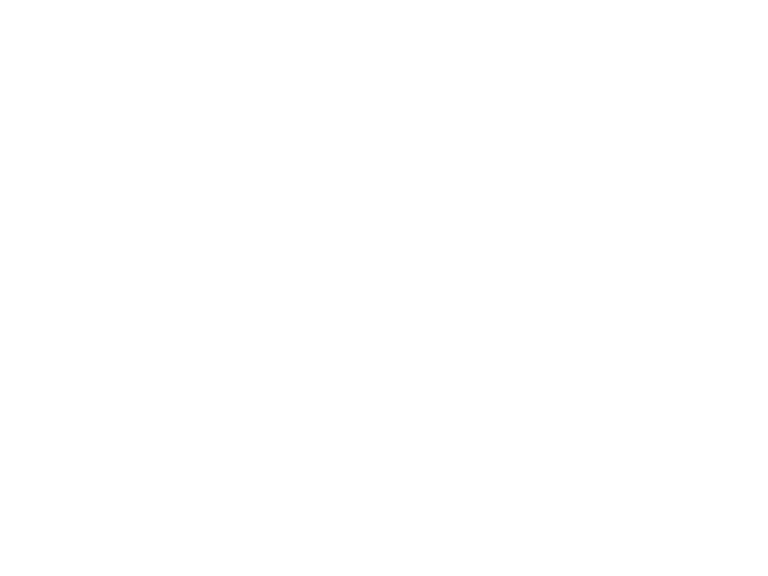

In [8]:
plt.figure()
plt.grid()

xx = np.linspace(-1.0, -0.5, npts)
for i in range(npts):
    yy[i] = fd[0]*dpol[0].subs([(x, xx[i])]) + fd[1]*dpol[1].subs([(x, xx[i])])
plt.plot(xx, yy)

xx = np.linspace(-0.5, 0.0, npts)
for i in range(npts):
    yy[i] = fd[1]*dpol[2].subs([(x, xx[i])]) + fd[2]*dpol[3].subs([(x, xx[i])])
plt.plot(xx, yy)

xx = np.linspace( 0.0, 0.5, npts)
for i in range(npts):
    yy[i] = fd[2]*dpol[4].subs([(x, xx[i])]) + fd[3]*dpol[5].subs([(x, xx[i])])
plt.plot(xx, yy)

xx = np.linspace( 0.5, 1.0, npts)
for i in range(npts):
    yy[i] = fd[3]*dpol[6].subs([(x, xx[i])]) + fd[4]*dpol[7].subs([(x, xx[i])])
plt.plot(xx, yy)

fc =fdx(x_data)
plt.plot([-1, -0.5, 0, 0.5, 1], fc, 'ko')

xx = np.linspace(-1.0, 1.0, npts)
for i in range(npts):
    zz[i]=fdx(xx[i])
plt.plot(xx, zz)

Como resultado del esquema de interpolación local la primera derivada se hace discontinua. Aunque las discontinuidades introducen errores en la solución estos se pueden reducir usando una mayor cantidad de sub-dominios. En análisis por elementos finitos este aumento de los sub-dominios, generando elementos de un menor tamaño se denomina refinamiento de la malla.

## Glosario de términos

**Nodo:** Un punto en el que se conoce la función a ser aproximada mediante un polinomio de interpolación.

**Sub-dominio:** Una porción del dominio computacional completo comprendido entre 2 puntos aunque probablemente con varios nodos internos.

**Elemento finito:** Un sub-dominio de tamaño predefinido y sus correspondientes funciones de interpolación.

**Elemento canónico:** Elemento finito de tamaño constante y con funciones de interpolación conocidas. Los elementos de tamaños arbitrarios se transforman en este para facilitar operaciones de calculo.

## Actividad para la clase



### Problema 1
Para la función $f(x) = {x^3} + 4{x^2} - 10$ en el rango $[-1.0, 1.0]$:

* Encuentre valores en los puntos nodales correspondientes a 4 sub-dominios, cada uno conformado por 3 nodos. Usando estos valores implemente un esquema de interpolación local usando polinomios de interpolación de orden 2.

* Grafique el polinomio de interpolación en cada sub-dominio y la función de aproximación $p(x)$ resultante.

* En la misma gráfica compare  $p(x)$ y $f(x)$. Adicionalmente, grafique la primera derivada de la función obtenida de $p(x)$ y de $f(x)$. 

### Problema 2
Para la función de Runge definida por:

$$f(x) = \frac{1}{{1 + 25{x^2}}}$$

implemente un esquema de interpolación con polinomios de Lagrange de primer orden y usando:
* sub-dominios de tamaño constante $\Delta x = 0.2$
* sub-dominios cuyo tamaño disminuye hacia los extremos del intervalo.

### Problema 3
Usando un script o Notebook independiente implemente un esquema de interpolación local usando un elemento canónico de tamaño 2.0 y úselo para aproximar la función de Runge discutida en las notas de clase.

## Formato del notebook

La siguiente celda cambia el formato del Notebook.

In [9]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()